In [8]:
# import the necessary packages
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def reorderPoints(points):

    points = points.reshape((4, 2))
    newPoints = np.zeros((4, 1, 2), dtype=np.int32)
    add = points.sum(1)

    newPoints[0] = points[np.argmin(add)]
    newPoints[3] = points[np.argmax(add)]
    diff = np.diff(points, axis=1)
    newPoints[1] = points[np.argmin(diff)]
    newPoints[2] = points[np.argmax(diff)]

    return newPoints


In [6]:
def ExtractTableWithCells(ImagePath):
    # =========================================Read Image==========================================
    img_BGR = cv2.imread(ImagePath, cv2.IMREAD_COLOR)
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)
    
    # =========================================PreProcessing==========================================
    Blurred_image_Median = cv2.medianBlur(img_gray, 5)
    Edged_Image = cv2.Canny(Blurred_image_Median, 180, 255)
    kernel = np.ones((5, 5), np.uint8)
    Dilated_img = cv2.dilate(Edged_Image, kernel, iterations=2)
    Erroded_img = cv2.erode(Dilated_img, kernel, iterations=1)
    
    # =========================================Detect and Warp the Table==========================================
    contrours_img = np.copy(Erroded_img)
    contours, _ = cv2.findContours(contrours_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    biggest_contour = None

    for contour in contours:
        area = cv2.contourArea(contour)
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        if area > max_area and len(approx) == 4:  # Check for rectangular shape
            max_area = area
            biggest_contour = approx

    if biggest_contour is None:
        print("No table detected.")
        return None, None, False

    # Reorder points and warp the perspective
    biggestContour = reorderPoints(biggest_contour)
    imgHeight, imgWidth = img_gray.shape
    pts1 = np.float32(biggestContour)
    pts2 = np.float32([[0, 0], [imgWidth, 0], [0, imgHeight], [imgWidth, imgHeight]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    WarpedGrayImage = cv2.warpPerspective(img_gray, matrix, (imgWidth, imgHeight))
    WarpedColoredImage = cv2.warpPerspective(img_RGB, matrix, (imgWidth, imgHeight))

    # =========================================Threshold and Extract Grid Lines==========================================
    _, img_bin = cv2.threshold(WarpedGrayImage, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = 255 - img_bin  # Invert colors

    # Extract vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img_bin.shape[1] // 150))
    vertical_lines = cv2.dilate(cv2.erode(img_bin, vertical_kernel, iterations=10), vertical_kernel, iterations=10)

    # Extract horizontal lines
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (img_bin.shape[1] // 150, 1))
    horizontal_lines = cv2.dilate(cv2.erode(img_bin, hor_kernel, iterations=10), hor_kernel, iterations=15)

    # Combine vertical and horizontal lines
    grid_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    grid_lines = cv2.erode(~grid_lines, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), iterations=3)
    _, grid_lines = cv2.threshold(grid_lines, 128, 255, cv2.THRESH_BINARY)

    # =========================================Find and Sort Contours==========================================
    contours, _ = cv2.findContours(grid_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: (b[1][1], b[1][0])))

    # Filter valid rectangles
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 8 and h > 15:  # Filter noise
            boxes.append([x, y, w, h])

    # Group boxes into rows and columns
    rows = []
    current_row = []
    previous_y = boxes[0][1]
    row_height_threshold = np.mean([h for _, _, _, h in boxes]) / 2  # Threshold to group rows

    for box in boxes:
        if abs(box[1] - previous_y) > row_height_threshold:
            rows.append(current_row)
            current_row = []
        current_row.append(box)
        previous_y = box[1]

    if current_row:
        rows.append(current_row)

    # =========================================Crop Cells into a Matrix (excluding columns 2 and 3)==========================================
    cropped_matrix = []
    for row in rows:
        row.sort(key=lambda b: b[0])  # Sort left-to-right
        if len(row) >= 6:  # Ensure there are 6 columns
            cropped_row = []
            # Exclude the second and third columns by skipping index 1 and 2 (0-indexed)
            for i in [0, 3, 4, 5]:  # Select 1st, 4th, 5th, and 6th rectangles (skip 2nd and 3rd)
                x, y, w, h = row[i]
                x=x-5
                cropped = WarpedColoredImage[y:y + h, x:x + w]
                cropped_row.append(cropped)
            cropped_matrix.append(cropped_row)

    # =========================================Display and Return Results==========================================
    print(f"Extracted {len(cropped_matrix)} rows with 4 columns (excluding 2nd and 3rd).")
    # cropped_matrix =cropped_matrix[1:]
    for i, row in enumerate(cropped_matrix):
        titles = [f"Row {i+1} Col {j+1}" for j in range(len(row))]
        show_images(row, titles)

    return cropped_matrix, WarpedColoredImage, True


Extracted 17 rows with 4 columns (excluding 2nd and 3rd).


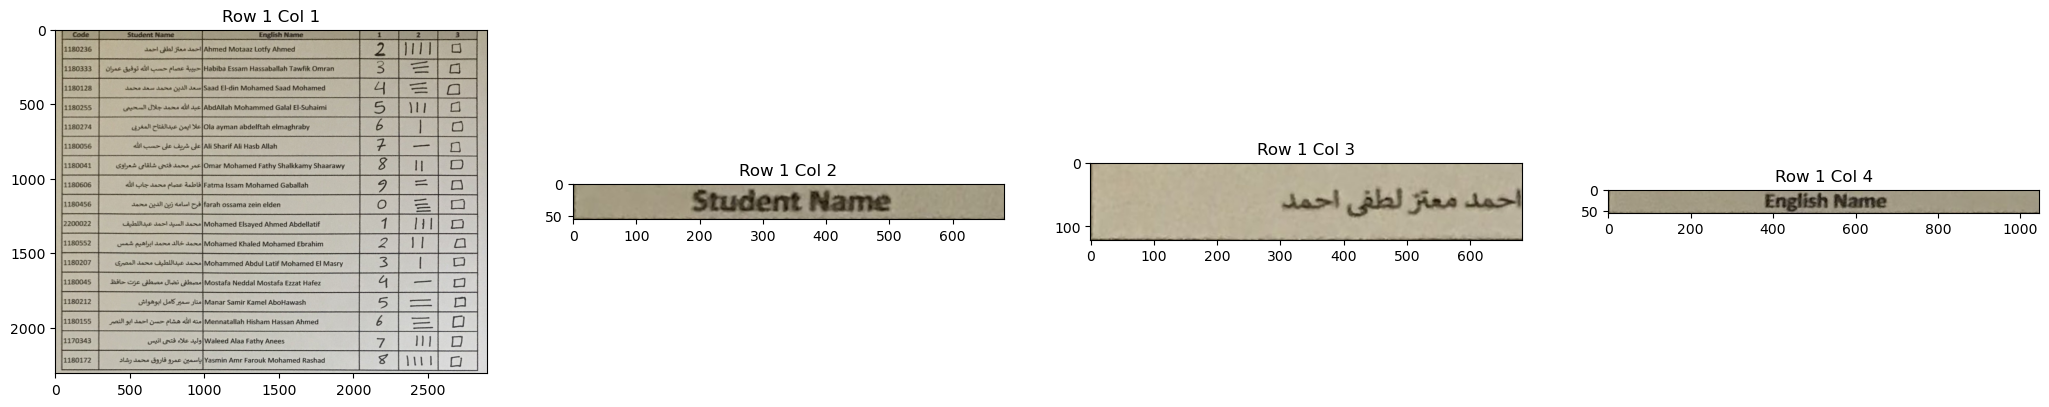

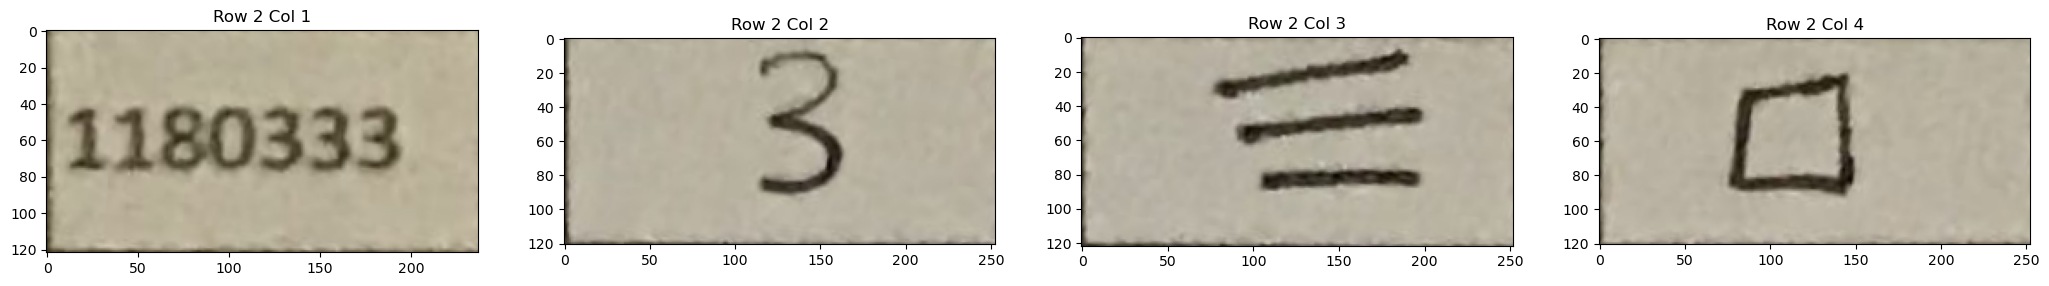

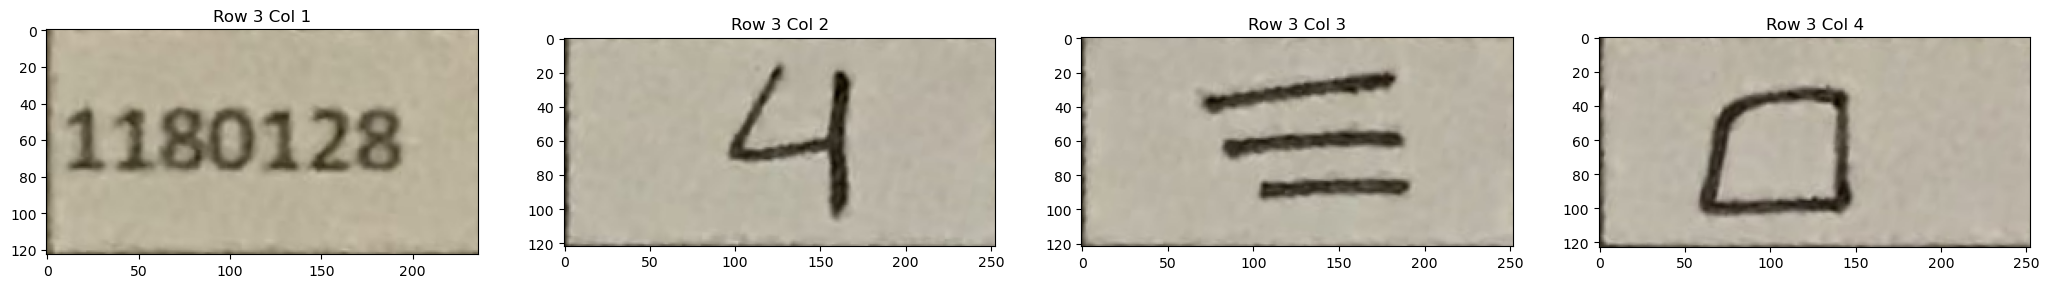

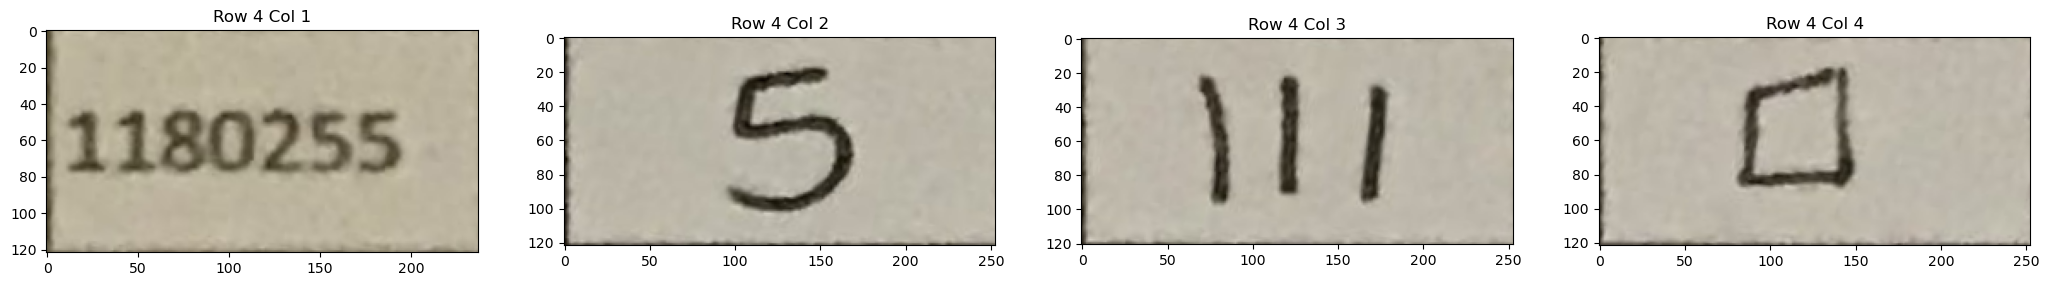

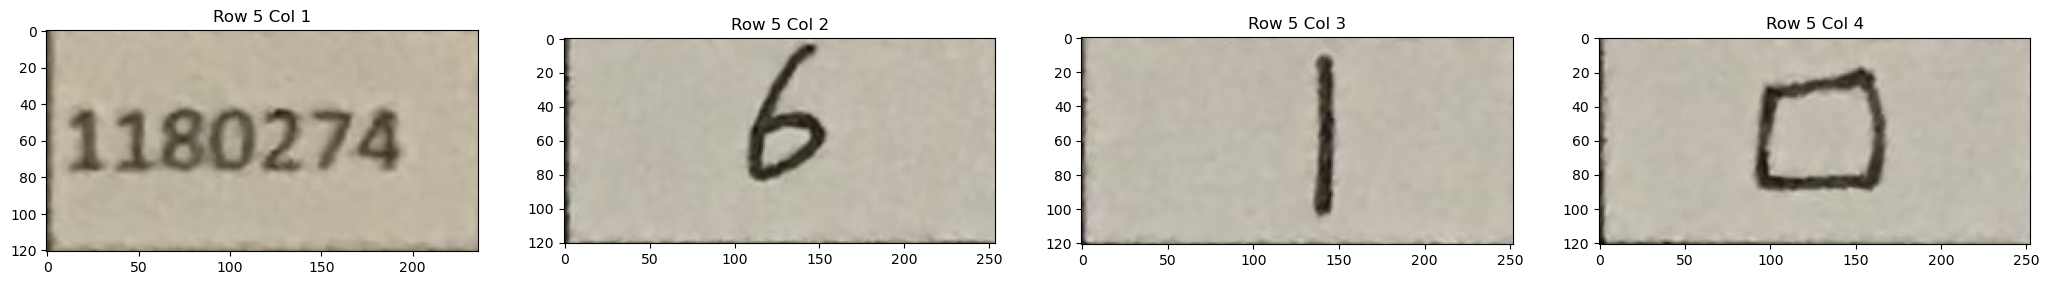

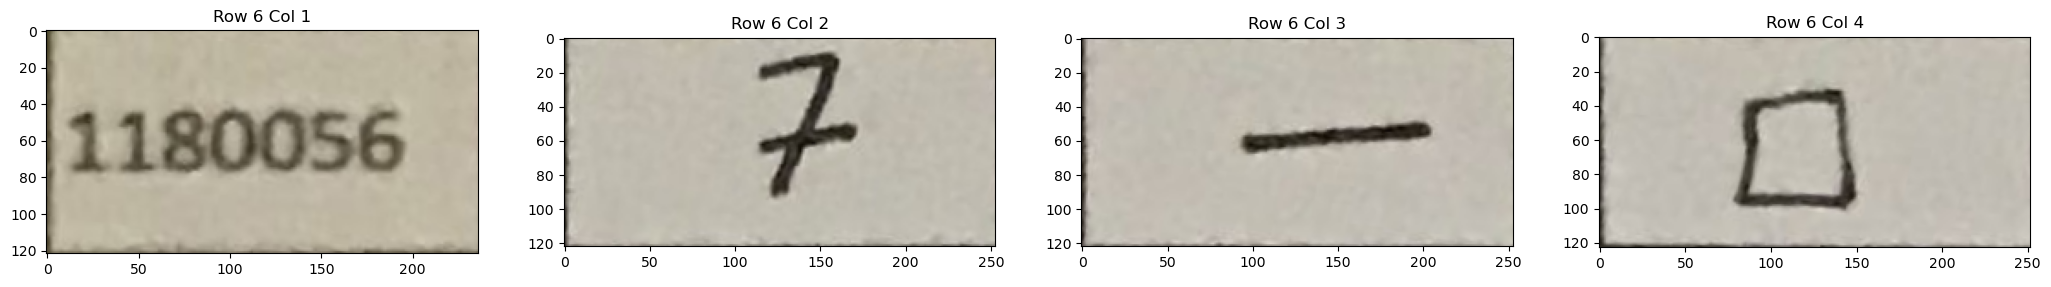

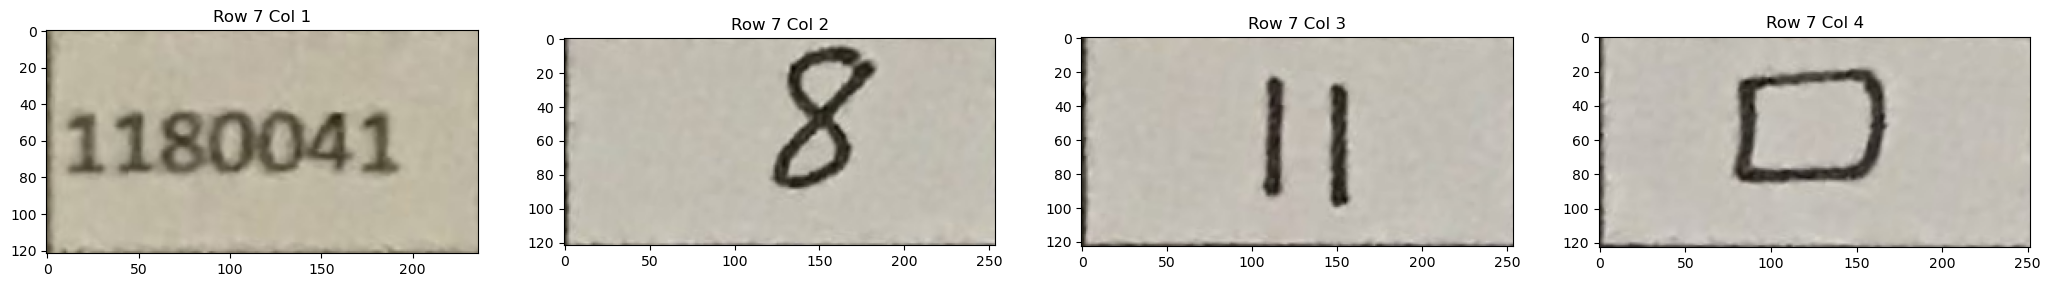

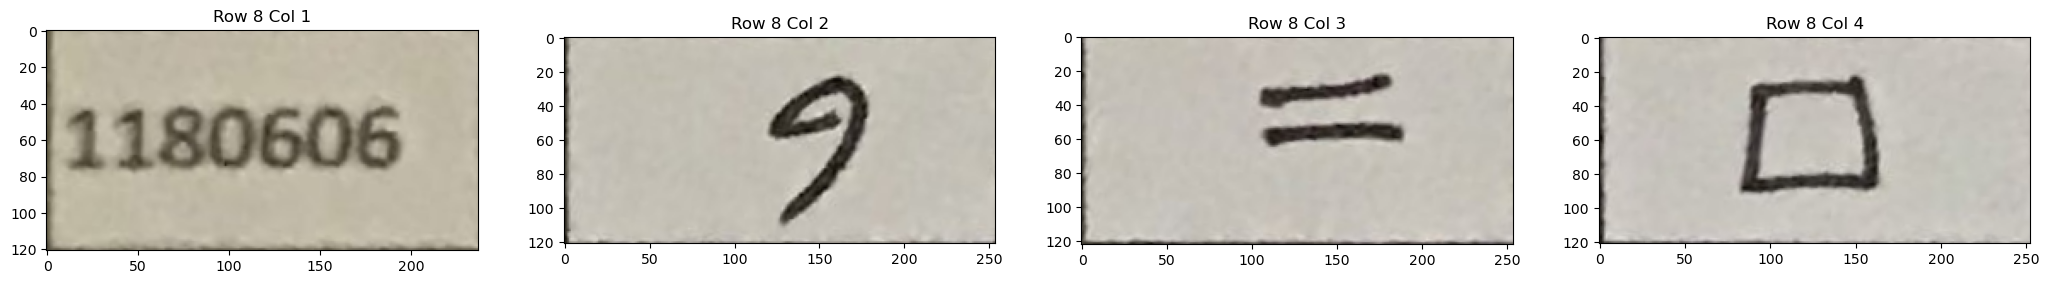

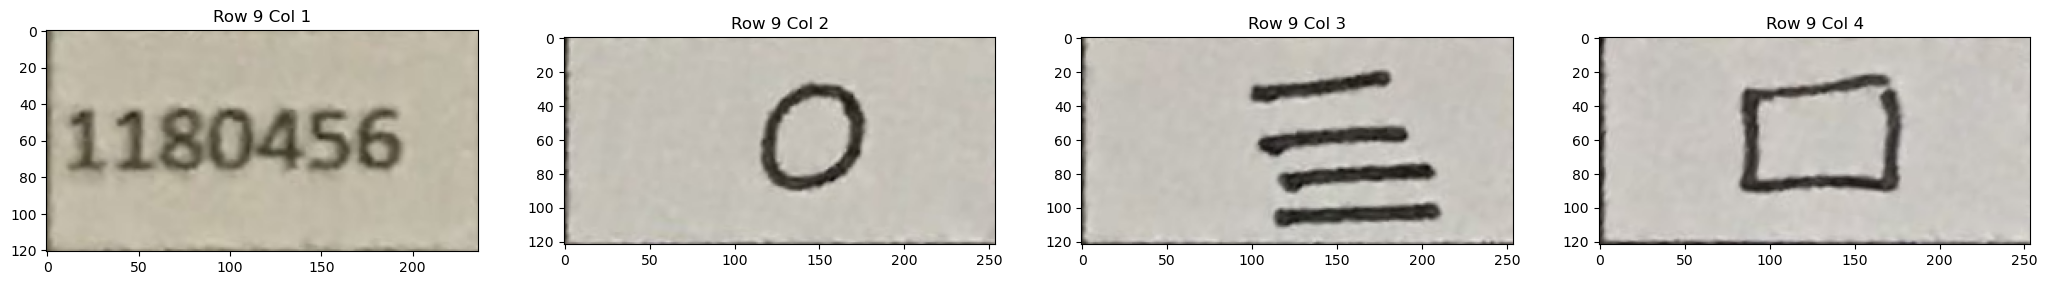

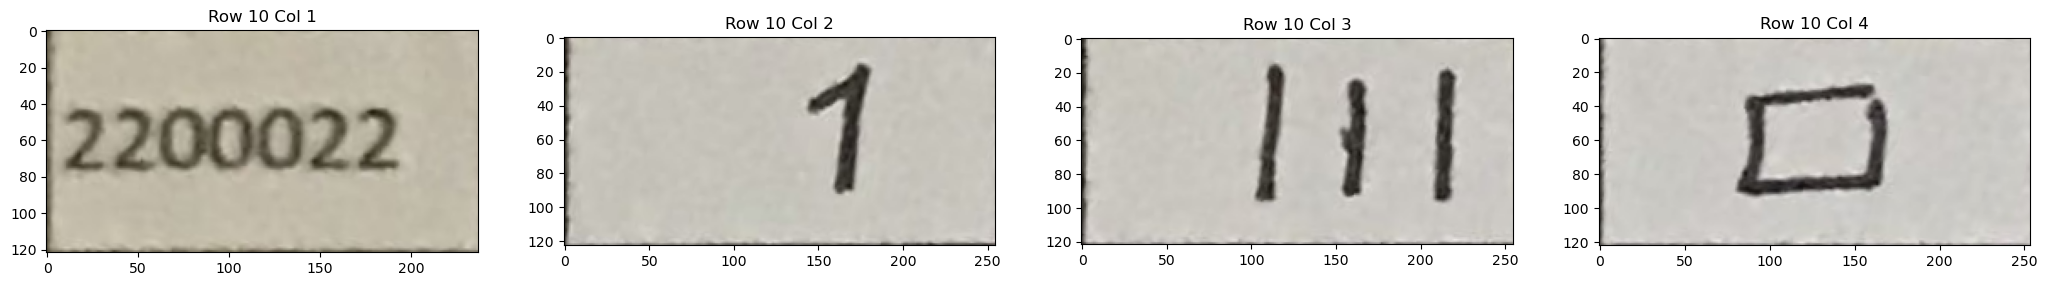

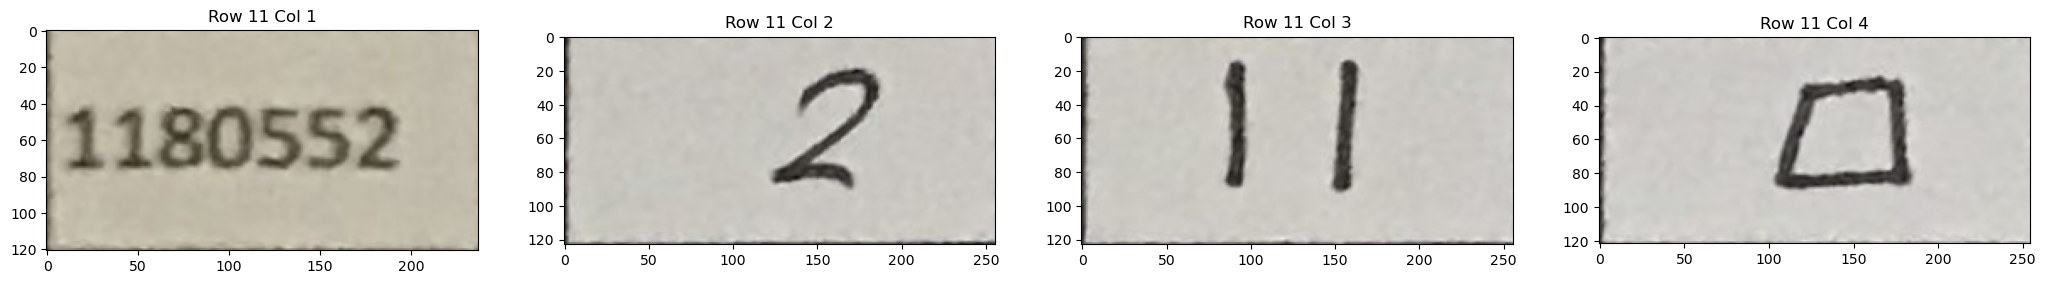

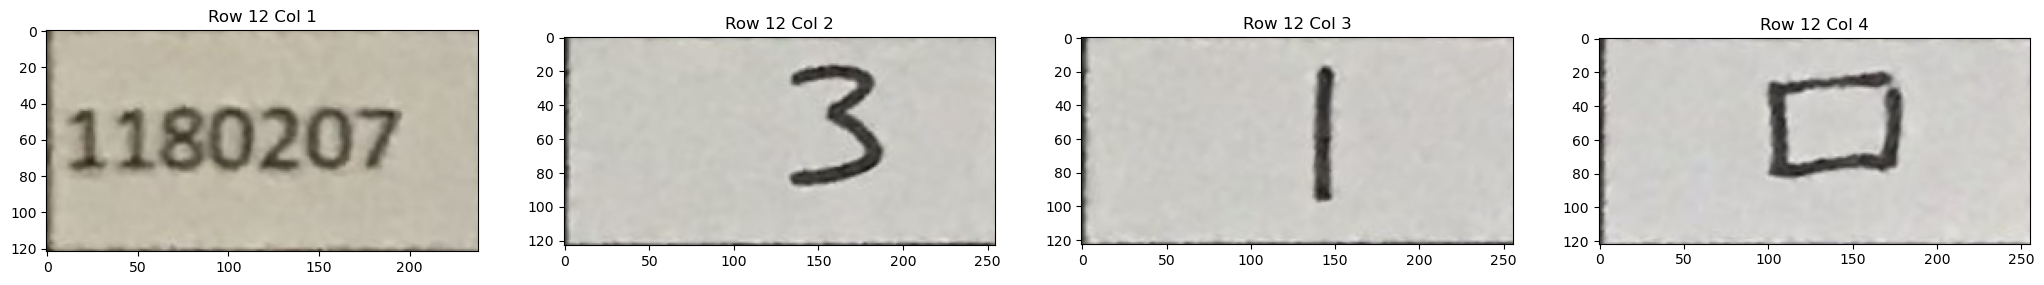

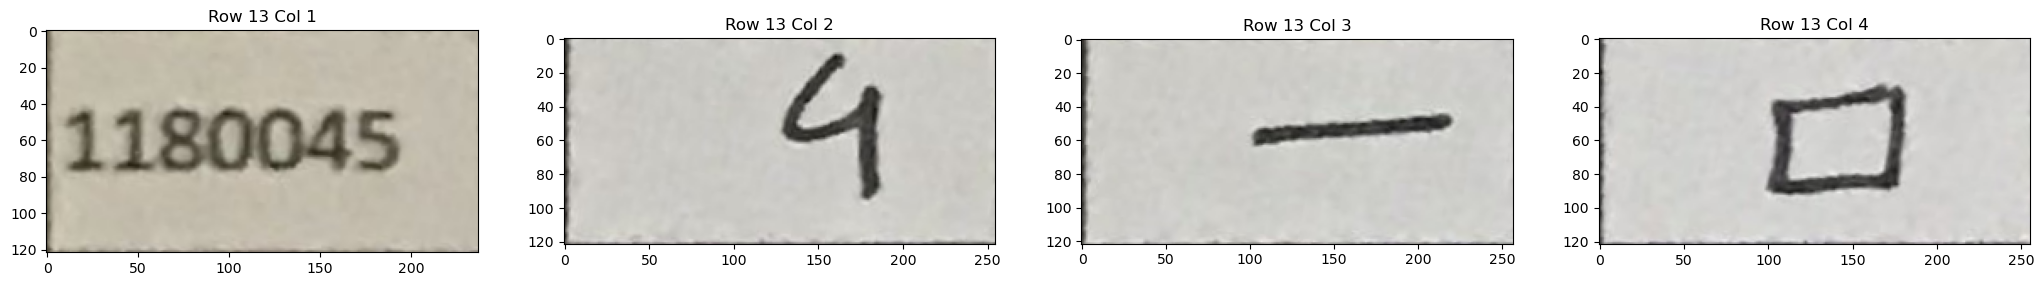

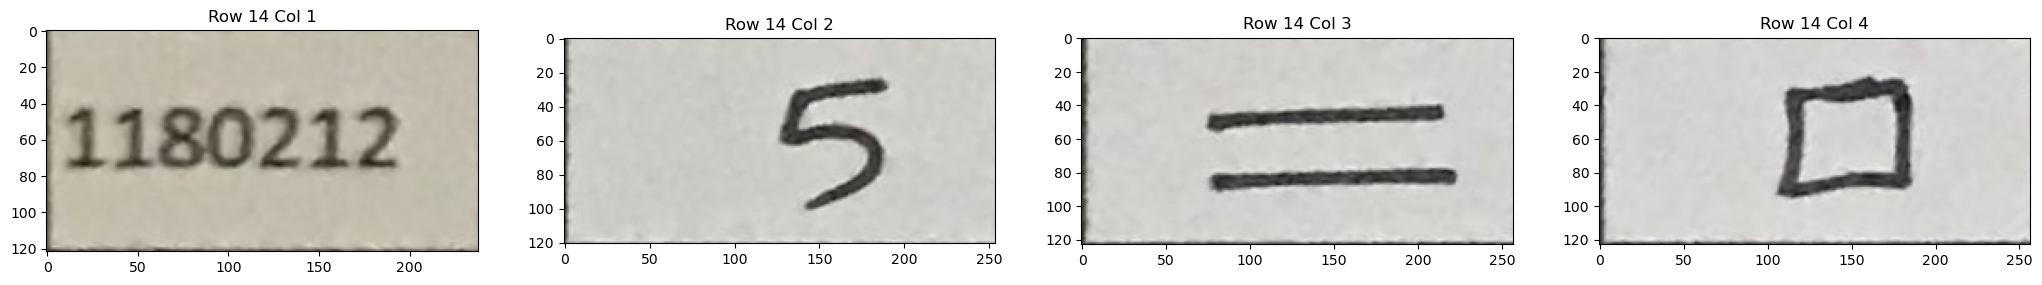

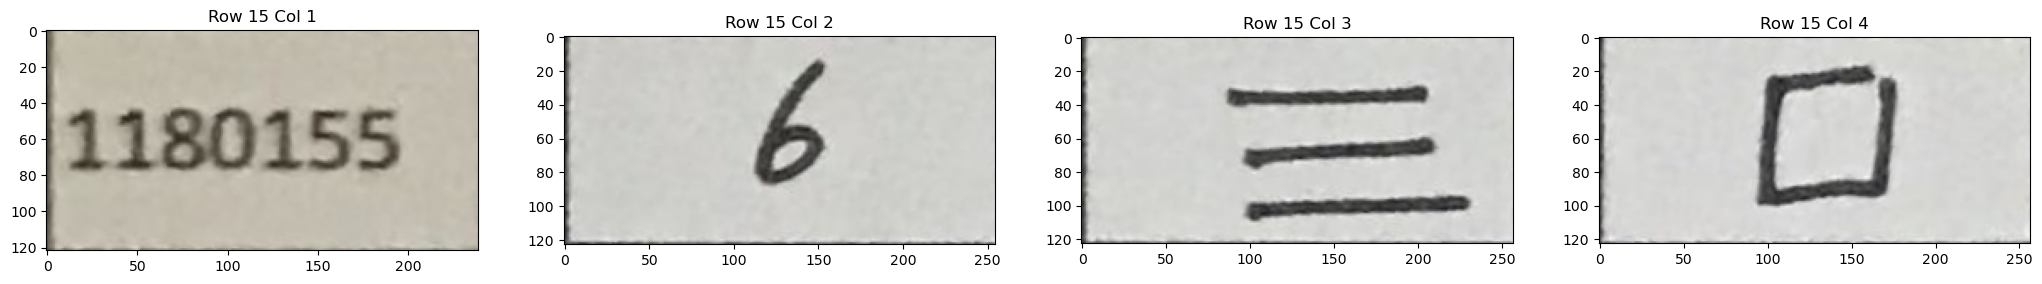

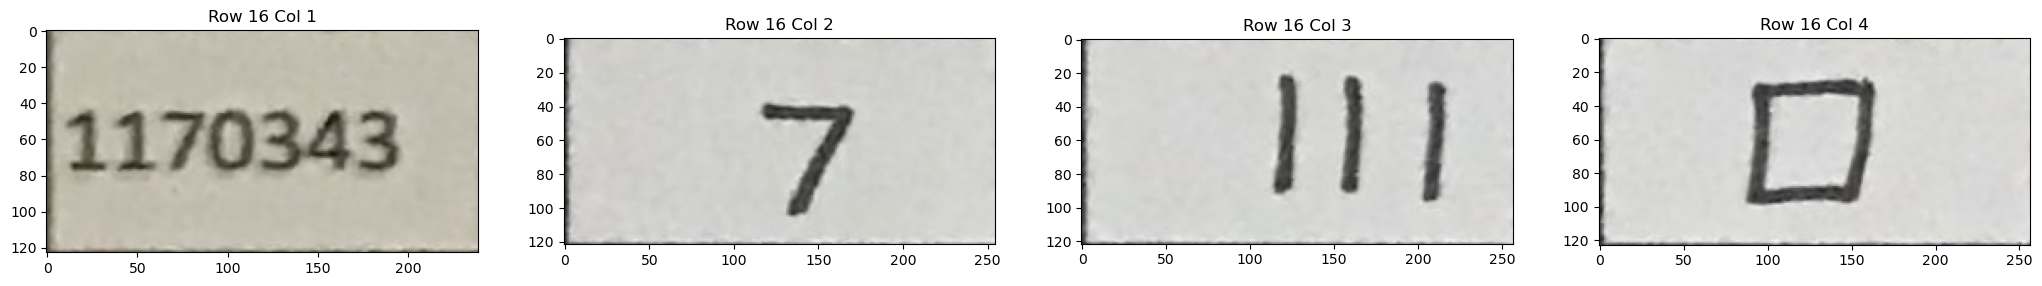

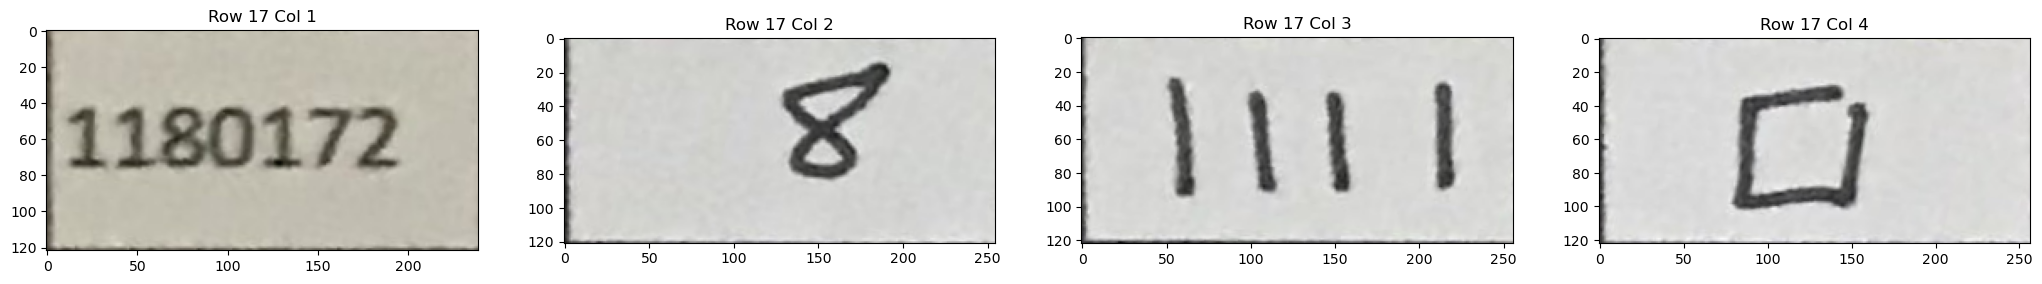

([[array([[[187, 178, 149],
           [187, 178, 149],
           [187, 178, 149],
           ...,
           [179, 173, 151],
           [178, 172, 150],
           [177, 171, 149]],
   
          [[188, 179, 150],
           [188, 179, 150],
           [187, 178, 149],
           ...,
           [179, 173, 151],
           [178, 172, 150],
           [176, 170, 148]],
   
          [[188, 179, 150],
           [187, 178, 149],
           [187, 178, 149],
           ...,
           [179, 173, 151],
           [177, 171, 149],
           [174, 168, 146]],
   
          ...,
   
          [[197, 191, 177],
           [196, 190, 176],
           [196, 190, 176],
           ...,
           [222, 222, 222],
           [221, 221, 221],
           [220, 220, 220]],
   
          [[197, 191, 177],
           [197, 191, 177],
           [197, 191, 177],
           ...,
           [222, 222, 222],
           [221, 221, 221],
           [220, 220, 220]],
   
          [[197, 191, 177],
        